In [23]:
import os
import re

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rcParams['image.cmap'] = 'viridis'

from IPython.html.widgets import interact

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Data loading/viewer functions

In [2]:
path_to_galfa = '/Users/erik/astrodata/galfa-hi'

In [14]:
galfacubes = {}
galfawcses = {}
def load_galfa_fn(objname, fn=None):
    if fn is None:
        f = galfacubes[objname]
        wcs = galfawcses[objname]
    else:
        if fn in galfacubes:
            if galfacubes.get(objname, None) is not galfacubes[fn]:
                raise ValueError('objname "{0}" and file "{1}" do not match'.format(objname, fn))
            f = galfacubes[fn]
            wcs = galfawcses[fn]
        else:
            f = galfacubes[fn] = fits.open(os.path.join(path_to_galfa, fn))
            galfacubes[objname] = f
            
            wcs = galfawcses[fn] = WCS(f[0].header)
            galfawcses[objname] = wcs        
        
    return f, f[0].data.T, wcs

In [15]:
def get_xyz_of_obj(objnameorfn, coo, vel):
    wcs = galfawcses[objnameorfn]
    return wcs.wcs_world2pix([[coo.ra.degree,coo.dec.degree, vel.to('m/s').value]],0)[0]

In [16]:
def show_target(objnameorfn, coo, vel, npix=50, vmin=None, vmax=None, box=3, imsum=None, 
                jyax=False, smooth=1, showall=False):
    datcube = load_galfa_fn(objnameorfn)[1]
    x, y, z = get_xyz_of_obj(objnameorfn, coo, vel)
    
    if showall:
        xslice = yslice = slice(None)
        edges = None
    else:
        xslice = slice(x - npix/2 + 1, x + npix/2 + 1)
        yslice = slice(y - npix/2 + 1, y + npix/2 + 1)
        edges = np.floor(x-npix/2)+.5, np.floor(x+npix/2)+.5, np.floor(y-npix/2)+.5, np.floor(y+npix/2)+.5
    
    if imsum is None or imsum==1:
        data = datcube[xslice, yslice, z].T
    else:
        if not hasattr(imsum, 'unit'):
            imsum = imsum*u.km/u.s
        lz = get_xyz_of_obj(objnameorfn, coo, vel - imsum/2)[-1]
        uz = get_xyz_of_obj(objnameorfn, coo, vel + imsum/2)[-1]
        data = datcube[xslice, yslice, lz:uz]
        data = np.sum(data,axis=-1).T
    
    
    plt.subplot(1,2,1)
    plt.imshow(data,interpolation='none',origin='lower', vmin=vmin, vmax=vmax, extent=edges)
    plt.colorbar()
    
    plt.axvline(x-box/2, color='k')
    plt.axvline(x+box/2, color='k')
    plt.axhline(y-box/2, color='k')
    plt.axhline(y+box/2, color='k')
    
    if showall:
        plt.xlim(x - npix/2, x + npix/2)
        plt.ylim(y - npix/2, y + npix/2)
        
    plt.title(objnameorfn)
    
    plt.subplot(1,2,2)
    dspec = datcube[x-box/2+1:x+box/2+1, y-box/2+1:y+box/2+1]
    print('Used',np.prod(dspec.shape)/dspec.shape[-1],'pix')
    dspec = dspec.sum(axis=0).sum(axis=0)
    vs = galfawcses[objnameorfn].wcs_pix2world(0, 0, np.arange(dspec.shape[-1]),0)[-1]/1000
    
    if smooth>1:
        kernel = np.hanning(smooth+2)
        kernel = kernel / np.sum(kernel)
        dspec = np.convolve(dspec, kernel, mode='same')
    
    plt.step(vs, dspec, where='mid')
    
    lv, uv = (vel-100*u.km/u.s).value, (vel+100*u.km/u.s).value
    plt.xlim(lv, uv)
    plt.ylim(np.min(dspec[(lv<vs)&(vs<uv)])-.05,np.max(dspec[(lv<vs)&(vs<uv)]) +.1)
    plt.xlabel('$v$ [km/s]')
    plt.ylabel('$T_b$ [K]')
    
    plt.axvline(vel.to('km/s').value,color='k', ls='--')
    
    if jyax:
        if jyax is True:
            jyax = 1*u.arcmin**2
        ktojy = (1*u.K).to(u.Jy, u.brightness_temperature(jyax, 21*u.cm)).value
        realax = plt.gca()
        yl = plt.ylim()
        plt.twinx()
        plt.ylim(yl[0]*ktojy, yl[1]*ktojy)
        plt.ylabel('Jy')

        plt.axes(realax)
    
    return vs,dspec

In [17]:

def fit_flux(vs, dspec, lv, uv, baselinevs=None, plotlines=False):
    vmsk = (lv<vs)&(vs<uv)
    if baselinevs:
        bldat = []
        blvs = []
        for lb, ub in baselinevs:
            blvs.extend(vs[(lb<vs)&(vs<ub)])
            bldat.extend(dspec[(lb<vs)&(vs<ub)])
        
        baseline = np.poly1d(np.polyfit(blvs, bldat, 1))
    else:
        baseline = lambda v: np.zeros_like(v)
        
    intspec = np.sum(dspec[vmsk]-baseline(vs[vmsk]))
    dv = np.diff(vs[vmsk]).mean()
    
    if plotlines:
        oxls = plt.xlim()
        oyls = plt.ylim()
        
        if baselinevs:
            for lb, ub in baselinevs:
                plt.axvline(lb, color='k', ls=':')
                plt.axvline(ub, color='k', ls=':')
        
        plt.axvline(lv, color='k')
        plt.axvline(uv, color='k')
        plt.plot(vs, baseline(vs), color='r')
        
        plt.xlim(*oxls)
        plt.ylim(*oyls)
    
    return intspec * dv * u.K * u.km/u.s

# Load targets

Targets come from the "ELVIS-GALFA-M31" notebook

In [47]:
targets_names = ['Sextans B', 'GR 8', 'KKH 86']
targets_coo = SkyCoord(ra=[150.00041667,  194.66833333,  208.63958333]*u.deg,
                       dec=[5.33222222,  14.2175,   4.24305556]*u.deg,
                       distance=[1.42560759,  2.17770977,  2.58226019]*u.Mpc)
targets_v = [304.0, 213.9, 287.2]*u.km/u.s

# Examine them interactively 

In [45]:
fns = os.listdir(path_to_galfa)
matches = [re.match('GALFA_HI_RA\+DEC_(.*?)\+(.*?)_W.fits.gz', fn) for fn in fns]

fns = [match.group(0) for match in matches if match is not None]
ras = [match.group(1) for match in matches if match is not None]
decs = [match.group(2) for match in matches if match is not None]

fn_scs = SkyCoord(ra=u.Quantity(ras, u.deg, dtype=float), 
                  dec=u.Quantity(decs, u.deg, dtype=float))

for name, coo in zip(targets_names, targets_coo):
    seps = fn_scs.separation(coo)
    idx = np.argmin(seps)
    print('Matched', name, 'to GALFA file', fns[idx], 'at a distance from the center of', seps[idx])
    
    # this function call associates the name with the file
    load_galfa_fn(name, fns[idx])

Matched Sextans B to GALFA file GALFA_HI_RA+DEC_148.00+02.35_W.fits.gz at a distance from the center of 3d35m18.1548s
Matched GR 8 to GALFA file GALFA_HI_RA+DEC_196.00+10.35_W.fits.gz at a distance from the center of 4d04m49.538s
Matched

 KKH 86 to GALFA file GALFA_HI_RA+DEC_212.00+02.35_W.fits.gz at a distance from the center of 3d51m07.0928s
Matched Leo P to GALFA file GALFA_HI_RA+DEC_148.00+10.35_W.fits.gz at a distance from the center of 10d34m18.7299s


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Used 64.0 pix


<function __main__.plot_and_line_flux>

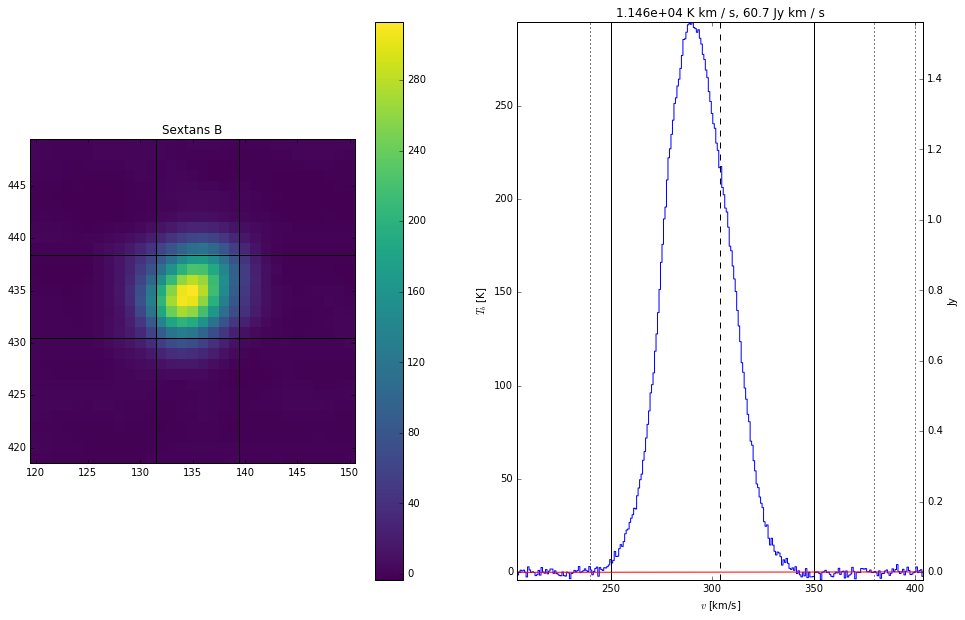

In [30]:
target_name = 'Sextans B'

targetidx = targets_names.index(target_name)
data = load_galfa_fn(target_name)[1]

def plot_and_line_flux(vplt=targets_v[targetidx].to('km/s').value, box=8, smooth=1, imsum=40):
    plt.figure(figsize=(16, 10))
    vs, dspec = show_target(target_name, targets_coo[targetidx], vplt*u.km/u.s, 31, box=box,imsum=imsum, 
                            jyax=True, smooth=smooth)
        
    tbdv = fit_flux(vs, dspec, 250,350,[(200, 240), (380,400)],plotlines=True)
    flxdv = (tbdv/(u.km/u.s)).to(u.Jy, u.brightness_temperature((1*u.arcmin)**2, 21*u.cm))*u.km/u.s
    plt.title('{0:.4}, {1:.4}'.format(tbdv, flxdv))

interact(plot_and_line_flux, vplt=(150,350), box=(1, 20), smooth=(1,9),imsum=(1,100))

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Used 64.0 pix


<function __main__.plot_and_line_flux>

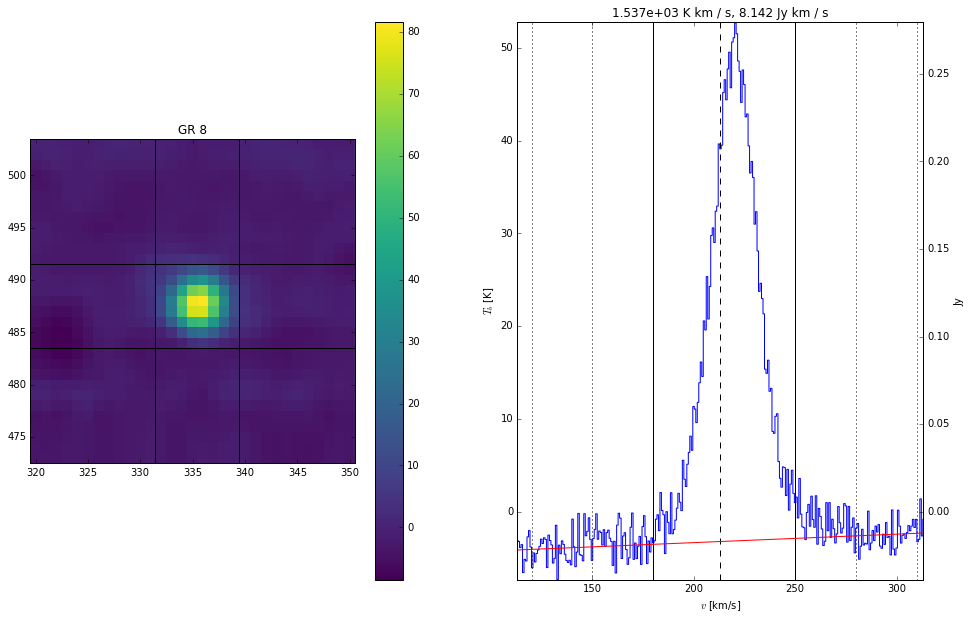

In [32]:
target_name = 'GR 8'

targetidx = targets_names.index(target_name)
data = load_galfa_fn(target_name)[1]

def plot_and_line_flux(vplt=targets_v[targetidx].to('km/s').value, box=8, smooth=1, imsum=40):
    plt.figure(figsize=(16, 10))
    vs, dspec = show_target(target_name, targets_coo[targetidx], vplt*u.km/u.s, 31, box=box,imsum=imsum, 
                            jyax=True, smooth=smooth)
        
    tbdv = fit_flux(vs, dspec, 180,250,[(120, 150), (280,310)],plotlines=True)
    flxdv = (tbdv/(u.km/u.s)).to(u.Jy, u.brightness_temperature((1*u.arcmin)**2, 21*u.cm))*u.km/u.s
    plt.title('{0:.4}, {1:.4}'.format(tbdv, flxdv))

interact(plot_and_line_flux, vplt=(150,350), box=(1, 20), smooth=(1,9),imsum=(1,100))

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Used 36.0 pix


<function __main__.plot_and_line_flux>

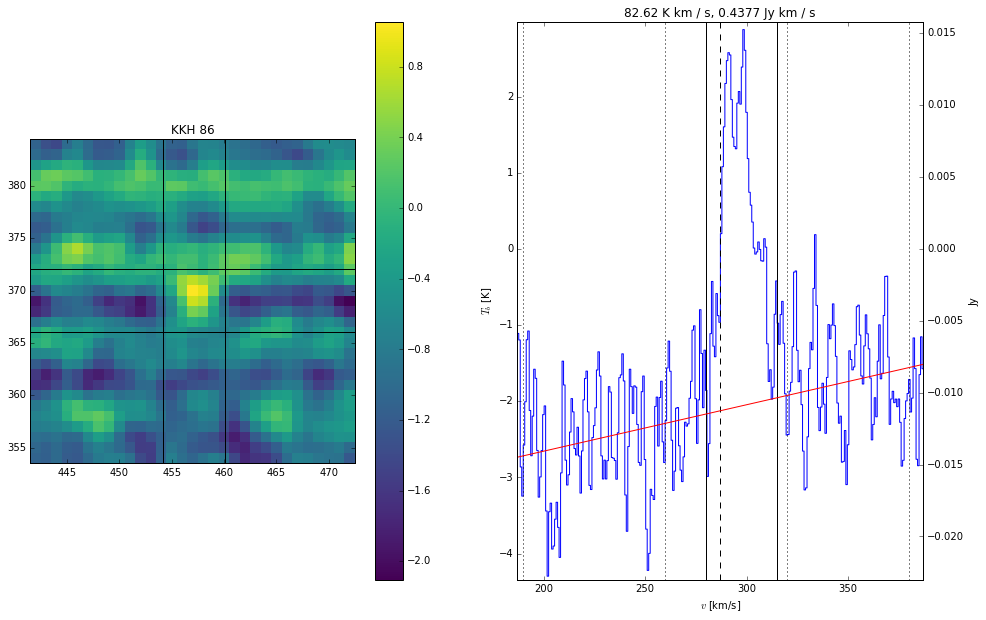

In [42]:
target_name = 'KKH 86'

targetidx = targets_names.index(target_name)
data = load_galfa_fn(target_name)[1]

def plot_and_line_flux(vplt=targets_v[targetidx].to('km/s').value, box=6, smooth=3, imsum=10):
    plt.figure(figsize=(16, 10))
    vs, dspec = show_target(target_name, targets_coo[targetidx], vplt*u.km/u.s, 31, box=box,imsum=imsum, 
                            jyax=True, smooth=smooth)
        
    tbdv = fit_flux(vs, dspec, 280,315,[(190, 260), (320,380)],plotlines=True)
    flxdv = (tbdv/(u.km/u.s)).to(u.Jy, u.brightness_temperature((1*u.arcmin)**2, 21*u.cm))*u.km/u.s
    plt.title('{0:.4}, {1:.4}'.format(tbdv, flxdv))

interact(plot_and_line_flux, vplt=(150,350), box=(1, 20), smooth=(1,9),imsum=(1,100))

# Blank space so page doesn't jump 